In [125]:
import lasagne
import theano
import theano.tensor as T
import numpy as np
from scipy.io import loadmat
import matplotlib.pylab as plt
%matplotlib inline
from IPython import display
import time

Make sure we generate the same data every time by fixing the seed

In [3]:
np.random.seed(42)

Data is the (x,y) position of a ball as it ricochets around in a box of size (xmin,xmax,ymin,ymax)

In [175]:
xmin,xmax,ymin,ymax = (-1,1,-1,1)
lower_bound = np.array([xmin,ymin])
upper_bound = np.array([xmax,ymax])

ndims = 2
nsteps = 100
nsequences = 10

def bounce_ball(pos,vel):
    for n in range(1,nsteps):
        pos_next = pos[n-1,:] + vel
        within_boundary = [lower_bound[d] < pos_next[d] < upper_bound[d] for d in range(ndims)]
        if not all(within_boundary):
            vel[~np.array(within_boundary)] *= -1
        pos[n,:] = pos[n-1,:]+vel
    return pos


x = np.zeros((nsequences,nsteps,2))
for s in range(nsequences):
    x0 = np.random.rand()*(xmax-xmin)+xmin
    y0 = np.random.rand()*(ymax-ymin)+ymin
    x[s,0,:] = np.array([x0,y0])

    vel = np.random.rand(2)
    vel = vel/(10*np.linalg.norm(vel))
    x[s,:,:] = bounce_ball(x[s,:,:],vel)

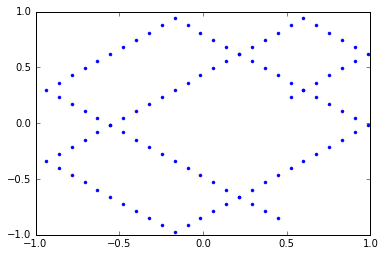

In [176]:
plt.plot(*x[5,:,:].T,'.')

KeyboardInterrupt: 

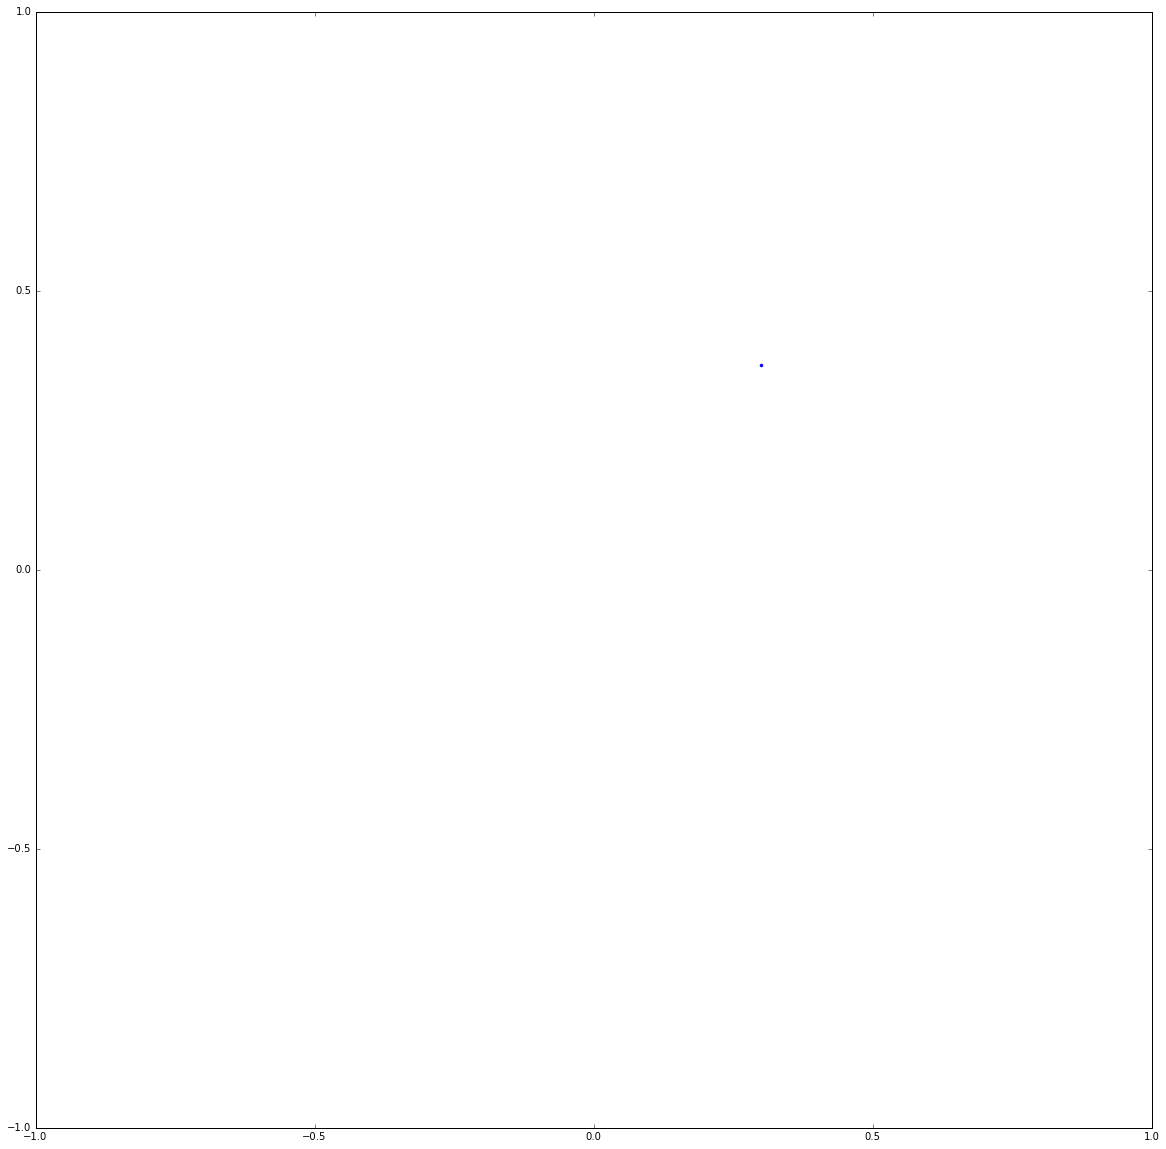

In [214]:
pos = x[3]
for n in range(nsteps):
    display.display(plt.clf());
    plt.plot(*pos[n,:].T,'.',color='b');
    plt.xlim(-1,1);
    plt.ylim(-1,1);
    display.clear_output(wait=True);
    display.display(plt.gcf());

Lasagne's GRUlayer expects a three-dimensional input (batch_size,seq_len,dimension_of_signal)

In [183]:
X = x

In [184]:
X.shape

(20, 100, 2)

The output is supposed to be the next frame

In [185]:
x = X[:,:-1]
y = X[:,1:]

In [186]:
x.shape,y.shape

((20, 99, 2), (20, 99, 2))

Lasagne also requires float32's for some reason (probably to save space)

In [187]:
x = x.astype(np.float32)
y = y.astype(np.float32)

Since Lasagne won't work with singular hidden units, the model has two, but we only use one in the cost function.

In [188]:
NUM_INPUTS = 1
NUM_UNITS_ENC = 30

In [189]:
#symbolic theano variables. Note that we are using imatrix for X since it goes into the embedding layer
x_sym = T.matrix()

In [190]:
x_sym = T.ftensor3()
y_sym = T.ftensor3()

First we try with a batch size of one, to test the code with long waiting times

In [191]:
x_first = x[0:10,:].astype(np.float32)
y_first = y[0:10,:].astype(np.float32)

In [192]:
x_first.shape,y_first.shape

((10, 99, 2), (10, 99, 2))

In [197]:
l_in = lasagne.layers.InputLayer((None,None,2), input_var = x_sym)
batch_size,seq_len,_ = l_in.input_var.shape
l_enc1 = lasagne.layers.GRULayer(l_in, num_units=NUM_UNITS_ENC, name='GRUEncoder')
#reshape
#calc error
#new RNN w error as input
#...
#calc cost
#T.grad(cost, params) 
l_enc2 = lasagne.layers.GRULayer(l_enc1, num_units=NUM_UNITS_ENC, name='GRUEncoder')
l_enc3 = lasagne.layers.GRULayer(l_enc2, num_units=NUM_UNITS_ENC, name='GRUEncoder')
l_reshape = lasagne.layers.reshape(l_enc3, (-1,NUM_UNITS_ENC))
l_dense = lasagne.layers.DenseLayer(l_reshape,2,nonlinearity=lasagne.nonlinearities.linear)
l_out = lasagne.layers.reshape(l_dense, (batch_size,seq_len,ndims))
# make sure output layer's range matches the range of input, fx with linear output layer
print(lasagne.layers.get_output(l_in, inputs={l_in: x_sym}).eval({x_sym: x_first}).shape)
print(lasagne.layers.get_output(l_enc1, inputs={l_in: x_sym}).eval({x_sym: x_first}).shape)
print(lasagne.layers.get_output(l_enc2, inputs={l_in: x_sym}).eval({x_sym: x_first}).shape)
print(lasagne.layers.get_output(l_enc3, inputs={l_in: x_sym}).eval({x_sym: x_first}).shape)
print(lasagne.layers.get_output(l_reshape, inputs={l_in: x_sym}).eval({x_sym: x_first}).shape)
print(lasagne.layers.get_output(l_dense, inputs={l_in: x_sym}).eval({x_sym: x_first}).shape)
print(lasagne.layers.get_output(l_out, inputs={l_in: x_sym}).eval({x_sym: x_first}).shape)

(10, 99, 2)
(10, 99, 30)
(10, 99, 30)
(10, 99, 30)
(990, 30)
(990, 2)
(10, 99, 2)


In [198]:
# cost function is mean absolute difference between predicted and actual next step.
predicted_values = lasagne.layers.get_output(l_out)
cost = T.mean(abs(predicted_values - y_sym))

In [199]:
cost.eval({x_sym: x_first,y_sym: y_first})

array(0.4967113686673373)

In [200]:
all_parameters = lasagne.layers.get_all_params([l_out], trainable=True)
#add grad clipping to avoid exploding gradients
all_grads = [T.clip(g,-3,3) for g in T.grad(cost, all_parameters)]
#updates = lasagne.updates.adam(all_grads, all_parameters, learning_rate=0.001)
updates = lasagne.updates.adam(all_grads, all_parameters, learning_rate=0.005)

In [201]:
print("Trainable Model Parameters")
print("-"*40)
for param in all_parameters:
    print(param, param.get_value().shape)
print("-"*40)

Trainable Model Parameters
----------------------------------------
GRUEncoder.W_in_to_updategate (2, 30)
GRUEncoder.W_hid_to_updategate (30, 30)
GRUEncoder.b_updategate (30,)
GRUEncoder.W_in_to_resetgate (2, 30)
GRUEncoder.W_hid_to_resetgate (30, 30)
GRUEncoder.b_resetgate (30,)
GRUEncoder.W_in_to_hidden_update (2, 30)
GRUEncoder.W_hid_to_hidden_update (30, 30)
GRUEncoder.b_hidden_update (30,)
GRUEncoder.W_in_to_updategate (30, 30)
GRUEncoder.W_hid_to_updategate (30, 30)
GRUEncoder.b_updategate (30,)
GRUEncoder.W_in_to_resetgate (30, 30)
GRUEncoder.W_hid_to_resetgate (30, 30)
GRUEncoder.b_resetgate (30,)
GRUEncoder.W_in_to_hidden_update (30, 30)
GRUEncoder.W_hid_to_hidden_update (30, 30)
GRUEncoder.b_hidden_update (30,)
GRUEncoder.W_in_to_updategate (30, 30)
GRUEncoder.W_hid_to_updategate (30, 30)
GRUEncoder.b_updategate (30,)
GRUEncoder.W_in_to_resetgate (30, 30)
GRUEncoder.W_hid_to_resetgate (30, 30)
GRUEncoder.b_resetgate (30,)
GRUEncoder.W_in_to_hidden_update (30, 30)
GRUEncoder.W

In [202]:
# compile training function (in C or somesuch)
train_func = theano.function([x_sym, y_sym], [cost, predicted_values], updates=updates)

In [203]:
c = 0
csts = []
preds = []
num_epochs = 3000
while c < num_epochs:
    cst, pred = train_func(x,y)
    csts.append(cst)
    preds.append(pred)
    c += 1
    #print(c)

In [204]:
while c < num_epochs*2:
    cst, pred = train_func(x,y)
    csts.append(cst)
    preds.append(pred)
    c += 1
    #print(c)

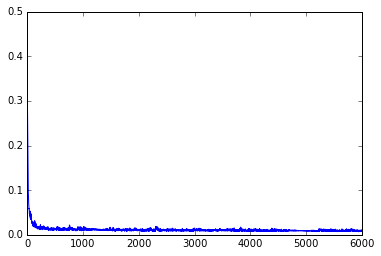

In [206]:
plt.plot(csts);

In [207]:
print(csts[-1])

0.008939447583353993


Compare prediction generated by a randomly initialized network

In [208]:
preds[0].shape

(20, 99, 2)

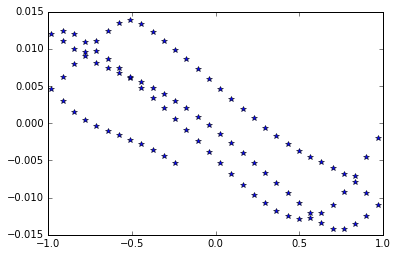

In [209]:
plt.plot(y_first[0,:,0].T.flatten(),preds[0][0,:,0].T.flatten(),'*')

to prediction by trained network (ideal is a straight line)

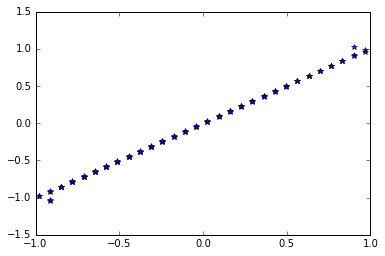

In [210]:
plt.plot(y_first[0,:,0].T.flatten(),preds[-1][0,:,0].T.flatten(),'*');

A few sample sequence comparisons:

In [211]:
sequence_idxs = np.random.choice(10,9,replace=False)

In [212]:
plt.rcParams['figure.figsize'] = (20,20)

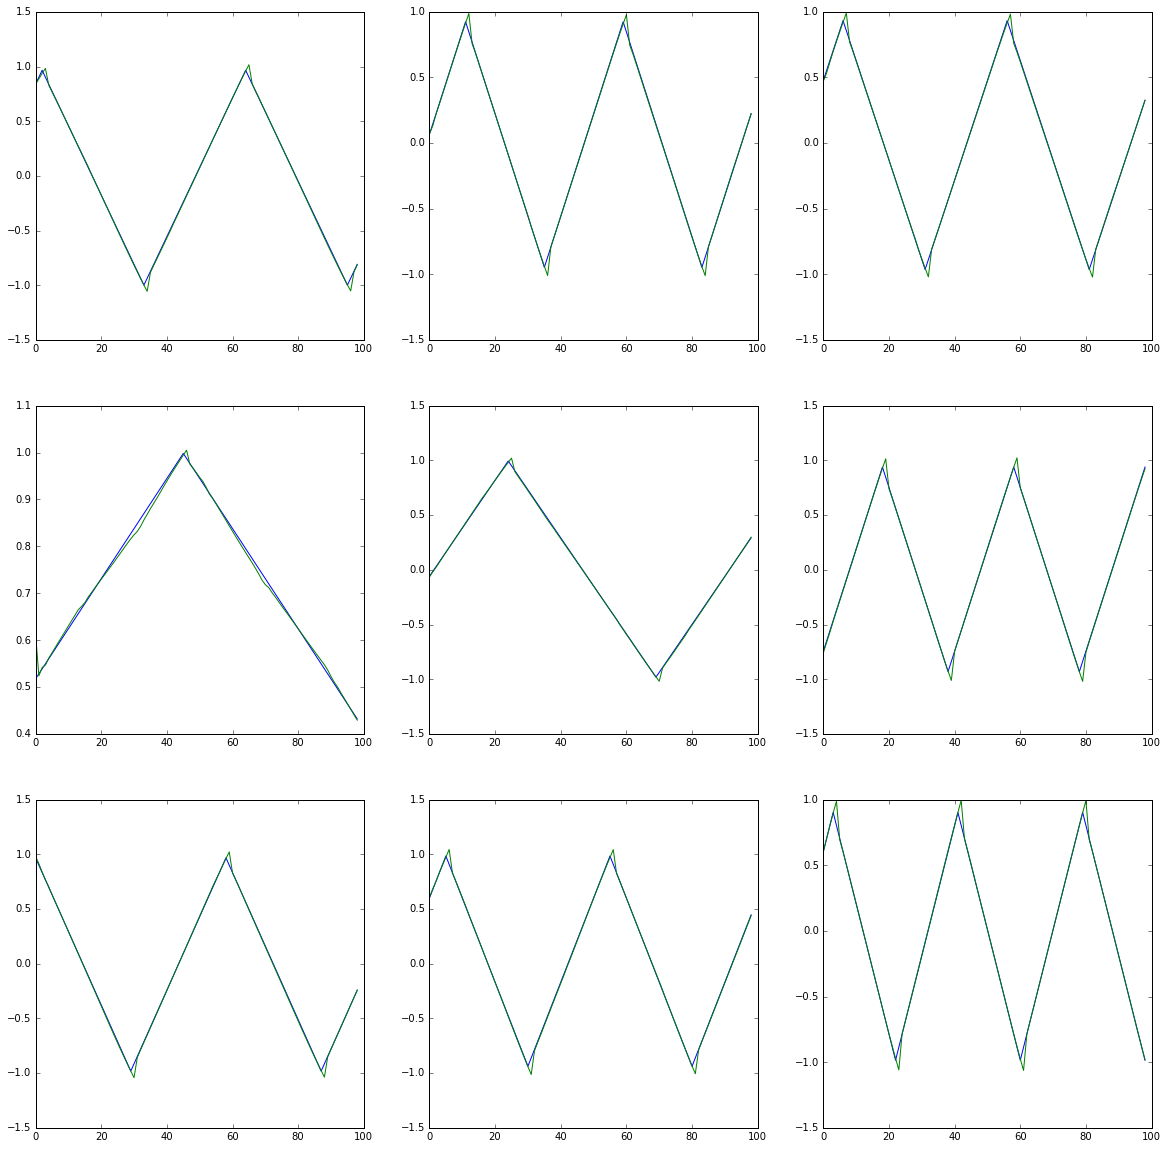

In [213]:
cc = 0
for i in sequence_idxs:
    cc += 1
    plt.subplot(3,3,cc)
    plt.plot(y_first[i,:,0].T)
    plt.plot(preds[-1][i,:,0].T)